<a href="https://colab.research.google.com/github/NoraHK3/DataSciProject/blob/main/Model_Attempt4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()

Saving all_images.zip to all_images.zip
Saving final_dataset_paths.csv to final_dataset_paths.csv


In [2]:
# === 1. Imports ===
import os
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0, MobileNetV2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [3]:
import zipfile
import os
import shutil

ZIP_FILE = "all_images.zip"
EXTRACT_DIR = "images"

# Remove existing directory if it exists
if os.path.exists(EXTRACT_DIR):
    shutil.rmtree(EXTRACT_DIR)

# Create directory
os.makedirs(EXTRACT_DIR, exist_ok=True)

# Extract zip
with zipfile.ZipFile(ZIP_FILE, 'r') as zip_ref:
    zip_ref.extractall(EXTRACT_DIR)

print("Images extracted to:", EXTRACT_DIR)



Images extracted to: images


In [4]:
import pandas as pd
import numpy as np
import os
import shutil
from PIL import Image, UnidentifiedImageError
from tqdm import tqdm
import matplotlib.pyplot as plt


In [5]:
# Load your metadata CSV (update filename if needed)
metadata_df = pd.read_csv("final_dataset_paths.csv")

metadata_df['image_file'] = metadata_df['image_file'].apply(lambda x: f"/content/images/{x}")

print("Loaded metadata_df with shape:", metadata_df.shape)
metadata_df.head()


Loaded metadata_df with shape: (1172, 4)


,dish_name,labels,image_file,scrape_date
0,Hijazi Almond Coffee,['Almond Coffee'],/content/images/img(1).jpg,30/09/2025
1,Shakeshawka Hijazi,['Shakshuka'],/content/images/img(2).jpg,30/09/2025
2,Kabsa,"['Rice', 'Meat']",/content/images/img(3).jpg,30/09/2025
3,Kleija,['Kleija'],/content/images/img(4).jpg,30/09/2025
4,Kabsa,"['Chicken', 'Rice']",/content/images/img(5).jpg,30/09/2025


In [6]:
import re

def safe_parse_labels(x):
    if not isinstance(x, str):
        return []

    # Remove brackets
    x = x.strip().lstrip("[").rstrip("]")

    # Split by comma
    parts = x.split(",")

    cleaned = []
    for p in parts:
        p = p.strip().strip("'").strip('"')   # remove quotes
        if p:                                 # ignore empty values
            cleaned.append(p)

    return cleaned

metadata_df['labels'] = metadata_df['labels'].apply(safe_parse_labels)


In [7]:
print(metadata_df['labels'].head())


0    [Almond Coffee]
1        [Shakshuka]
2       [Rice, Meat]
3           [Kleija]
4    [Chicken, Rice]
Name: labels, dtype: object


In [8]:
from collections import Counter

all_labels = []
for lst in metadata_df['labels']:
    all_labels.extend(lst)

label_counts = Counter(all_labels)

print("Total unique labels:", len(label_counts))
label_counts


Total unique labels: 52


Counter({'Almond Coffee': 12,
         'Shakshuka': 16,
         'Rice': 352,
         'Meat': 180,
         'Kleija': 12,
         'Chicken': 232,
         'Basbousa': 12,
         'Foul': 8,
         'Vegetable': 60,
         'Areeqa': 12,
         'Musabeeb': 16,
         'Jareesh': 44,
         'Sambousa': 24,
         'Bread': 52,
         'Soup': 36,
         'Saleeg': 20,
         'Luqaimat': 12,
         'Maqshoosh': 12,
         'Maamoul': 12,
         'Mutabbaq': 12,
         'Lahm Bi Ajeen': 16,
         'Molokhiya': 12,
         'Moussaka': 12,
         'Kibbeh': 12,
         'Qursan': 24,
         'Marqouq': 20,
         'Matazeez': 16,
         'Saleeg ': 8,
         'Cream Caramel': 12,
         'Jelly': 12,
         'Mohalabiya': 28,
         'Umm Ali': 12,
         'Kunafa': 20,
         'Salad': 108,
         'Potato': 24,
         'Roz Bi Laban': 12,
         'Pasta': 20,
         'Fish': 20,
         'Yogurt': 32,
         'Bishamel': 16,
         'Hummus': 16,
    

In [9]:
# Keep only original rows (no "-" in filename)
original_df = metadata_df[metadata_df['image_file'].apply(lambda x: "-" not in x)]


In [10]:
from collections import Counter

all_labels = []
for lst in original_df['labels']:
    all_labels.extend(lst)

label_counts = Counter(all_labels)

print("Total unique labels:", len(label_counts))
print(label_counts)


Total unique labels: 52
Counter({'Rice': 88, 'Chicken': 58, 'Meat': 45, 'Salad': 27, 'Vegetable': 15, 'Bread': 13, 'Jareesh': 11, 'Cake': 10, 'Soup': 9, 'Yogurt': 8, 'Mohalabiya': 7, 'Sambousa': 6, 'Qursan': 6, 'Potato': 6, 'Saleeg': 5, 'Marqouq': 5, 'Kunafa': 5, 'Pasta': 5, 'Fish': 5, 'Shakshuka': 4, 'Musabeeb': 4, 'Lahm Bi Ajeen': 4, 'Matazeez': 4, 'Bishamel': 4, 'Hummus': 4, 'Pastry': 4, 'Almond Coffee': 3, 'Kleija': 3, 'Basbousa': 3, 'Areeqa': 3, 'Luqaimat': 3, 'Maqshoosh': 3, 'Maamoul': 3, 'Mutabbaq': 3, 'Molokhiya': 3, 'Moussaka': 3, 'Kibbeh': 3, 'Cream Caramel': 3, 'Jelly': 3, 'Umm Ali': 3, 'Roz Bi Laban': 3, 'Qishd': 3, 'Henainee': 3, 'Mousakhan': 3, 'Falafel': 3, 'Grape Leaves': 3, 'Foul': 2, 'Saleeg ': 2, 'Meat Soup': 2, 'Muhammara': 2, 'Afees': 2, 'Fatteh': 2})


In [11]:
rare_labels = {label: count for label, count in label_counts.items() if count < 2}

print("Labels with fewer than 2 original samples:")
rare_labels


Labels with fewer than 2 original samples:


{}

In [12]:
metadata_df['labels'] = metadata_df['labels'].apply(
    lambda x: eval(x) if isinstance(x, str) else x
)

A. MULTI-LABEL STRATIFIED SPLIT

STEP 1 — Extract grouping key (original image ID)

In [13]:
import re
import pandas as pd

# Extract group key: everything inside parentheses
def extract_group_id(path):
    fname = path.split('/')[-1]
    match = re.match(r"img\((\d+)\)", fname)
    return int(match.group(1)) if match else None

metadata_df['group_id'] = metadata_df['image_file'].apply(extract_group_id)


STEP 2 — Build grouped label sets (one label list per original image)

In [14]:
# Group labels by group_id (original image)
grouped_labels = (
    metadata_df.groupby("group_id")["labels"]
    .apply(lambda rows: sorted(list(set(sum(rows, [])))))   # union of labels
)

STEP 3 — Multi-label Stratified Split (IterativeStratification)

In [15]:
!pip install scikit-multilearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 3.1 MB/s eta 0:00:00


In [16]:
from skmultilearn.model_selection import IterativeStratification
import numpy as np

# Build multilabel matrix (binary indicator)
unique_labels = sorted({label for row in grouped_labels for label in row})
label_to_idx = {lab: i for i, lab in enumerate(unique_labels)}

def encode_multilabel(label_list):
    arr = np.zeros(len(unique_labels), dtype=int)
    for lab in label_list:
        arr[label_to_idx[lab]] = 1
    return arr

Y = np.array(grouped_labels.apply(encode_multilabel).to_list())
group_ids = grouped_labels.index.to_list()
group_ids = np.array(group_ids)

# Perform stratified split
splitter = IterativeStratification(
    n_splits=2,
    order=2
)

train_idx, test_idx = next(splitter.split(group_ids.reshape(-1, 1), Y))

train_groups = group_ids[train_idx]
test_groups = group_ids[test_idx]

print("TRAIN GROUPS:", len(train_groups))
print("TEST GROUPS:", len(test_groups))


TRAIN GROUPS: 145
TEST GROUPS: 148


STEP 4 — Expand groups back to full images

In [17]:
train_df = metadata_df[metadata_df['group_id'].isin(train_groups)].reset_index(drop=True)
test_df  = metadata_df[metadata_df['group_id'].isin(test_groups)].reset_index(drop=True)

print("Train image rows:", len(train_df))
print("Test image rows:", len(test_df))

Train image rows: 580
Test image rows: 592


STEP 5 — Build one-hot/multi-hot vector for training

In [18]:
def encode_labels(label_list):
    arr = np.zeros(len(unique_labels), dtype=int)
    for lab in label_list:
        arr[label_to_idx[lab]] = 1
    return arr

train_df['label_multihot'] = train_df['labels'].apply(lambda x: np.array(encode_labels(x), dtype=np.float32))
test_df['label_multihot']  = test_df['labels'].apply(lambda x: np.array(encode_labels(x), dtype=np.float32))


NUM_CLASSES = len(unique_labels)
NUM_CLASSES


52

B. MODEL DEFINITIONS (MobileNetV2 + EfficientNetB0)

Custom multi-label accuracy

In [19]:
import tensorflow as tf

def multilabel_accuracy(y_true, y_pred):
    y_pred_binary = tf.cast(y_pred > 0.5, tf.float32)
    correct = tf.cast(tf.reduce_all(tf.equal(y_true, y_pred_binary), axis=1), tf.float32)
    return tf.reduce_mean(correct)

MobileNetV2

In [20]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2

def build_mobilenetv2_multilabel(num_classes):
    base = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224,224,3))
    base.trainable = False

    x = layers.GlobalAveragePooling2D()(base.output)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(num_classes, activation="sigmoid")(x)

    model = models.Model(base.input, out)
    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["binary_accuracy", multilabel_accuracy]
    )
    return model

EfficientNetB0

In [21]:
from tensorflow.keras.applications import EfficientNetB0

def build_efficientnet_multilabel(num_classes):
    base = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(224,224,3))
    base.trainable = False

    x = layers.GlobalAveragePooling2D()(base.output)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(num_classes, activation="sigmoid")(x)

    model = models.Model(base.input, out)
    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["binary_accuracy", multilabel_accuracy]
    )
    return model

NASNetMobile

In [22]:
import tensorflow as tf

def build_nasnet_mobile_multilabel(num_classes):
    base_model = tf.keras.applications.NASNetMobile(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )

    base_model.trainable = False   # Freeze backbone

    x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
    x = tf.keras.layers.Dropout(0.3)(x)
    output = tf.keras.layers.Dense(num_classes, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=base_model.input, outputs=output)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss='binary_crossentropy',
        metrics=['binary_accuracy']
    )

    return model


C. TRAINING (50 epochs + EarlyStopping)

In [23]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

Dataset generators

In [24]:
import tensorflow as tf
import numpy as np
from PIL import Image

# Parameters
BATCH_SIZE = 16
IMG_SIZE = (224, 224)

# --- Preprocessing function ---
def preprocess_image(path, label):
    """
    path: string tensor (image path)
    label: np.array multilabel vector
    """
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = img / 255.0  # normalize to [0,1]
    return img, label

# --- Prepare labels as a single stacked NumPy array ---
train_labels_array = np.stack(train_df['label_multihot'].values)
test_labels_array  = np.stack(test_df['label_multihot'].values)

# --- Create tf.data.Dataset objects ---
train_ds = tf.data.Dataset.from_tensor_slices((train_df['image_file'].values, train_labels_array))
train_ds = train_ds.shuffle(500, seed=42).map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((test_df['image_file'].values, test_labels_array))
test_ds = test_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print("Train dataset:", train_ds)
print("Test dataset:", test_ds)


Train dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 52), dtype=tf.float32, name=None))>
Test dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 52), dtype=tf.float32, name=None))>


Train MobileNetV2

In [25]:
mobilenet = build_mobilenetv2_multilabel(NUM_CLASSES)

history_mobilenet = mobilenet.fit(
    train_ds,          # <-- use tf.data.Dataset
    validation_data=test_ds,  # <-- use tf.data.Dataset
    epochs=50,
    callbacks=[early_stop]
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - binary_accuracy: 0.8620 - loss: 0.3092 - multilabel_accuracy: 0.0187 - val_binary_accuracy: 0.9746 - val_loss: 0.1016 - val_multilabel_accuracy: 0.0743
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - binary_accuracy: 0.9720 - loss: 0.0929 - multilabel_accuracy: 0.1238 - val_binary_accuracy: 0.9762 - val_loss: 0.0902 - val_multilabel_accuracy: 0.0861
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - binary_accuracy: 0.9809 - loss: 0.0615 - multilabel_accuracy: 0.2503 - val_binary_accuracy: 0.9764 - val_loss: 0.0870 - val_multilabel_accuracy: 0.1470
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - binary_accuracy: 0.9864 - loss: 0.0419 - multilabel_accuracy: 0.4531 - val_binary_accuracy: 0.9774 - val_loss: 0.0877 - val_multilabel_accuracy: 0.1284
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - binary_accuracy: 0.9906 - loss: 0.0299 - multilabel_accuracy: 0.5916 - val_binary_a

In [42]:
y_pred_mn = mobilenet.predict(test_ds)
y_pred_mn_bin = (y_pred_mn >= 0.5).astype(int)


37/37 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step


In [43]:
y_true = np.stack(test_df['label_multihot'].values)


In [44]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Per-label metrics
precision_mn, recall_mn, f1_mn, support_mn = precision_recall_fscore_support(
    y_true, y_pred_mn_bin, average=None, zero_division=0
)

# Micro & Macro metrics
precision_mn_micro, recall_mn_micro, f1_mn_micro, _ = precision_recall_fscore_support(
    y_true, y_pred_mn_bin, average="micro", zero_division=0
)

precision_mn_macro, recall_mn_macro, f1_mn_macro, _ = precision_recall_fscore_support(
    y_true, y_pred_mn_bin, average="macro", zero_division=0
)


In [45]:
metrics_mn_df = pd.DataFrame({
    "Label": unique_labels,
    "Precision": precision_mn,
    "Recall": recall_mn,
    "F1-Score": f1_mn,
    "Support": support_mn
})

print("\n===== PER LABEL METRICS (MobileNetV2) =====")
print(metrics_mn_df)



===== PER LABEL METRICS (MobileNetV2) =====
            Label  Precision    Recall  F1-Score  Support
0           Afees   0.000000  0.000000  0.000000        4
1   Almond Coffee   0.000000  0.000000  0.000000        4
2          Areeqa   0.000000  0.000000  0.000000        8
3        Basbousa   0.000000  0.000000  0.000000        8
4        Bishamel   0.000000  0.000000  0.000000        8
5           Bread   0.000000  0.000000  0.000000       28
6            Cake   0.000000  0.000000  0.000000       20
7         Chicken   0.725806  0.387931  0.505618      116
8   Cream Caramel   0.000000  0.000000  0.000000        8
9         Falafel   0.000000  0.000000  0.000000        4
10         Fatteh   0.000000  0.000000  0.000000        4
11           Fish   0.000000  0.000000  0.000000       12
12           Foul   0.000000  0.000000  0.000000        4
13   Grape Leaves   0.000000  0.000000  0.000000        4
14       Henainee   0.000000  0.000000  0.000000        4
15         Hummus   0.00000

In [46]:
print("\n===== MobileNetV2 Macro & Micro Averages =====")
print(f"Macro Precision: {precision_mn_macro:.4f}")
print(f"Macro Recall:    {recall_mn_macro:.4f}")
print(f"Macro F1-score:  {f1_mn_macro:.4f}")

print("\nMicro Precision:  {:.4f}".format(precision_mn_micro))
print("Micro Recall:     {:.4f}".format(recall_mn_micro))
print("Micro F1-score:   {:.4f}".format(f1_mn_micro))



===== MobileNetV2 Macro & Micro Averages =====
Macro Precision: 0.1226
Macro Recall:    0.0719
Macro F1-score:  0.0800

Micro Precision:  0.6988
Micro Recall:     0.3275
Micro F1-score:   0.4460


In [47]:
def get_active_labels(binary_row, label_names):
    return [label_names[i] for i, val in enumerate(binary_row) if val == 1]


In [48]:
num_samples = 30
rows_mn = []

for i in range(min(num_samples, len(y_true))):
    true_labs = get_active_labels(y_true[i], unique_labels)
    pred_labs = get_active_labels(y_pred_mn_bin[i], unique_labels)
    rows_mn.append([i, true_labs, pred_labs])

comparison_mn_df = pd.DataFrame(rows_mn, columns=["Sample Index", "True Labels", "Predicted Labels"])

print("\n===== SAMPLE PREDICTIONS (MobileNetV2) =====")
print(comparison_mn_df)



===== SAMPLE PREDICTIONS (MobileNetV2) =====
    Sample Index        True Labels Predicted Labels
0              0        [Shakshuka]               []
1              1           [Kleija]               []
2              2         [Basbousa]               []
3              3             [Rice]           [Rice]
4              4             [Foul]               []
5              5  [Meat, Vegetable]               []
6              6           [Areeqa]           [Rice]
7              7         [Musabeeb]               []
8              8         [Basbousa]               []
9              9    [Chicken, Rice]           [Rice]
10            10         [Sambousa]               []
11            11          [Jareesh]               []
12            12            [Bread]               []
13            13        [Maqshoosh]               []
14            14            [Bread]               []
15            15          [Maamoul]               []
16            16  [Chicken, Saleeg]               []


Train EfficientNetB0

In [31]:
efficientnet = build_efficientnet_multilabel(NUM_CLASSES)

history_efficientnet = efficientnet.fit(
    train_ds,
    validation_data=test_ds,
    epochs=50,
    callbacks=[early_stop]
)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 114s 3s/step - binary_accuracy: 0.8629 - loss: 0.3578 - multilabel_accuracy: 0.0045 - val_binary_accuracy: 0.9719 - val_loss: 0.1159 - val_multilabel_accuracy: 0.0000e+00
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 133s 3s/step - binary_accuracy: 0.9651 - loss: 0.1271 - multilabel_accuracy: 0.0094 - val_binary_accuracy: 0.9719 - val_loss: 0.1070 - val_multilabel_accuracy: 0.0000e+00
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 176s 3s/step - binary_accuracy: 0.9694 - loss: 0.1207 - multilabel_accuracy: 0.0046 - val_binary_accuracy: 0.9719 - val_loss: 0.1071 - val_multilabel_accuracy: 0.0000e+00
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 126s 3s/step - binary_accuracy: 0.9703 - loss: 0.1162 - multilabel_accuracy: 0.0023 - val_binary_accuracy: 0.9719 - val_loss: 0.1068 - val_multilabel_accuracy: 0.0000e+00
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - binary_accuracy: 0.9706 - loss: 0.1139 - multilabel_accuracy

In [50]:
y_pred_eff = efficientnet.predict(test_ds)
y_pred_eff_bin = (y_pred_eff >= 0.5).astype(int)


37/37 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step


In [51]:
y_true = np.stack(test_df['label_multihot'].values)


In [52]:
from sklearn.metrics import precision_recall_fscore_support

# Per-label metrics
precision_eff, recall_eff, f1_eff, support_eff = precision_recall_fscore_support(
    y_true, y_pred_eff_bin, average=None, zero_division=0
)

# Micro metrics
precision_eff_micro, recall_eff_micro, f1_eff_micro, _ = precision_recall_fscore_support(
    y_true, y_pred_eff_bin, average="micro", zero_division=0
)

# Macro metrics
precision_eff_macro, recall_eff_macro, f1_eff_macro, _ = precision_recall_fscore_support(
    y_true, y_pred_eff_bin, average="macro", zero_division=0
)


In [53]:
metrics_eff_df = pd.DataFrame({
    "Label": unique_labels,
    "Precision": precision_eff,
    "Recall": recall_eff,
    "F1-Score": f1_eff,
    "Support": support_eff
})

print("\n===== PER LABEL METRICS (EfficientNet) =====")
print(metrics_eff_df)



===== PER LABEL METRICS (EfficientNet) =====
            Label  Precision  Recall  F1-Score  Support
0           Afees        0.0     0.0       0.0        4
1   Almond Coffee        0.0     0.0       0.0        4
2          Areeqa        0.0     0.0       0.0        8
3        Basbousa        0.0     0.0       0.0        8
4        Bishamel        0.0     0.0       0.0        8
5           Bread        0.0     0.0       0.0       28
6            Cake        0.0     0.0       0.0       20
7         Chicken        0.0     0.0       0.0      116
8   Cream Caramel        0.0     0.0       0.0        8
9         Falafel        0.0     0.0       0.0        4
10         Fatteh        0.0     0.0       0.0        4
11           Fish        0.0     0.0       0.0       12
12           Foul        0.0     0.0       0.0        4
13   Grape Leaves        0.0     0.0       0.0        4
14       Henainee        0.0     0.0       0.0        4
15         Hummus        0.0     0.0       0.0        8
16

In [54]:
print("\n===== EfficientNet Macro & Micro Averages =====")
print(f"Macro Precision: {precision_eff_macro:.4f}")
print(f"Macro Recall:    {recall_eff_macro:.4f}")
print(f"Macro F1-score:  {f1_eff_macro:.4f}")

print("\nMicro Precision: {:.4f}".format(precision_eff_micro))
print("Micro Recall:    {:.4f}".format(recall_eff_micro))
print("Micro F1-score:  {:.4f}".format(f1_eff_micro))



===== EfficientNet Macro & Micro Averages =====
Macro Precision: 0.0000
Macro Recall:    0.0000
Macro F1-score:  0.0000

Micro Precision: 0.0000
Micro Recall:    0.0000
Micro F1-score:  0.0000


In [55]:
def get_active_labels(binary_row, label_names):
    return [label_names[i] for i, val in enumerate(binary_row) if val == 1]


In [56]:
num_samples = 30
rows_eff = []

for i in range(min(num_samples, len(y_true))):
    true_labs = get_active_labels(y_true[i], unique_labels)
    pred_labs = get_active_labels(y_pred_eff_bin[i], unique_labels)
    rows_eff.append([i, true_labs, pred_labs])

comparison_eff_df = pd.DataFrame(rows_eff, columns=["Sample Index", "True Labels", "Predicted Labels"])

print("\n===== SAMPLE PREDICTIONS (EfficientNet) =====")
print(comparison_eff_df)



===== SAMPLE PREDICTIONS (EfficientNet) =====
    Sample Index        True Labels Predicted Labels
0              0        [Shakshuka]               []
1              1           [Kleija]               []
2              2         [Basbousa]               []
3              3             [Rice]               []
4              4             [Foul]               []
5              5  [Meat, Vegetable]               []
6              6           [Areeqa]               []
7              7         [Musabeeb]               []
8              8         [Basbousa]               []
9              9    [Chicken, Rice]               []
10            10         [Sambousa]               []
11            11          [Jareesh]               []
12            12            [Bread]               []
13            13        [Maqshoosh]               []
14            14            [Bread]               []
15            15          [Maamoul]               []
16            16  [Chicken, Saleeg]               []

Train NASNetMobile

In [34]:
nasnet = build_nasnet_mobile_multilabel(NUM_CLASSES)

history_nasnet = nasnet.fit(
    train_ds,
    validation_data=test_ds,
    epochs=50,
    callbacks=[early_stop]
)


19993432/19993432 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 170s 4s/step - binary_accuracy: 0.6286 - loss: 0.6517 - val_binary_accuracy: 0.9196 - val_loss: 0.3534
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 103s 3s/step - binary_accuracy: 0.9131 - loss: 0.3266 - val_binary_accuracy: 0.9696 - val_loss: 0.2125
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 140s 3s/step - binary_accuracy: 0.9617 - loss: 0.2118 - val_binary_accuracy: 0.9717 - val_loss: 0.1605
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step - binary_accuracy: 0.9697 - loss: 0.1626 - val_binary_accuracy: 0.9719 - val_loss: 0.1371
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 101s 3s/step - binary_accuracy: 0.9709 - loss: 0.1415 - val_binary_accuracy: 0.9722 - val_loss: 0.1247
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 132s 4s/step - binary_accuracy: 0.9719 - loss: 0.1266 - val_binary_accuracy: 0.9724 - val_loss: 0.1172
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step - binary_accuracy: 0.9706 - loss: 0.1203 - val_binar

In [35]:
import numpy as np

# Get model predictions on entire test set
y_pred = nasnet.predict(test_ds)
y_pred_bin = (y_pred >= 0.5).astype(int)


37/37 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step


In [36]:
# Extract true labels from test_df
y_true = np.stack(test_df['label_multihot'].values)


In [37]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Per-label metrics
precision, recall, f1, support = precision_recall_fscore_support(
    y_true, y_pred_bin, average=None, zero_division=0
)

# Micro & Macro metrics
precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(
    y_true, y_pred_bin, average="micro", zero_division=0
)

precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
    y_true, y_pred_bin, average="macro", zero_division=0
)


In [38]:
import pandas as pd

metrics_df = pd.DataFrame({
    "Label": unique_labels,
    "Precision": precision,
    "Recall": recall,
    "F1-Score": f1,
    "Support": support
})

print("\n===== PER LABEL METRICS (NASNet) =====")
print(metrics_df)



===== PER LABEL METRICS (NASNet) =====
            Label  Precision    Recall  F1-Score  Support
0           Afees   0.000000  0.000000  0.000000        4
1   Almond Coffee   0.000000  0.000000  0.000000        4
2          Areeqa   0.000000  0.000000  0.000000        8
3        Basbousa   0.000000  0.000000  0.000000        8
4        Bishamel   0.000000  0.000000  0.000000        8
5           Bread   0.000000  0.000000  0.000000       28
6            Cake   0.000000  0.000000  0.000000       20
7         Chicken   0.661538  0.370690  0.475138      116
8   Cream Caramel   0.000000  0.000000  0.000000        8
9         Falafel   0.000000  0.000000  0.000000        4
10         Fatteh   0.000000  0.000000  0.000000        4
11           Fish   0.000000  0.000000  0.000000       12
12           Foul   0.000000  0.000000  0.000000        4
13   Grape Leaves   0.000000  0.000000  0.000000        4
14       Henainee   0.000000  0.000000  0.000000        4
15         Hummus   0.000000  0.

In [39]:
print("\n===== NASNet Macro & Micro Averages =====")
print(f"Macro Precision: {precision_macro:.4f}")
print(f"Macro Recall:    {recall_macro:.4f}")
print(f"Macro F1-score:  {f1_macro:.4f}")

print("\nMicro Precision:  {:.4f}".format(precision_micro))
print("Micro Recall:     {:.4f}".format(recall_micro))
print("Micro F1-score:   {:.4f}".format(f1_micro))



===== NASNet Macro & Micro Averages =====
Macro Precision: 0.0683
Macro Recall:    0.0284
Macro F1-score:  0.0381

Micro Precision:  0.7070
Micro Recall:     0.1759
Micro F1-score:   0.2817


In [40]:
def get_active_labels(binary_row, label_names):
    return [label_names[i] for i, val in enumerate(binary_row) if val == 1]

num_samples = 30
rows = []

for i in range(min(num_samples, len(y_true))):
    true_labs = get_active_labels(y_true[i], unique_labels)
    pred_labs = get_active_labels(y_pred_bin[i], unique_labels)
    rows.append([i, true_labs, pred_labs])

comparison_df = pd.DataFrame(rows, columns=["Sample Index", "True Labels", "Predicted Labels"])

print("\n===== SAMPLE PREDICTIONS (NASNet) =====")
print(comparison_df)



===== SAMPLE PREDICTIONS (NASNet) =====
    Sample Index        True Labels Predicted Labels
0              0        [Shakshuka]           [Rice]
1              1           [Kleija]               []
2              2         [Basbousa]        [Chicken]
3              3             [Rice]           [Rice]
4              4             [Foul]               []
5              5  [Meat, Vegetable]               []
6              6           [Areeqa]               []
7              7         [Musabeeb]               []
8              8         [Basbousa]               []
9              9    [Chicken, Rice]               []
10            10         [Sambousa]               []
11            11          [Jareesh]               []
12            12            [Bread]               []
13            13        [Maqshoosh]               []
14            14            [Bread]               []
15            15          [Maamoul]               []
16            16  [Chicken, Saleeg]               []
17   

In [57]:
import matplotlib.pyplot as plt

def plot_history(history, title):
    plt.figure(figsize=(8,5))
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.title(title)
    plt.legend()
    plt.show()


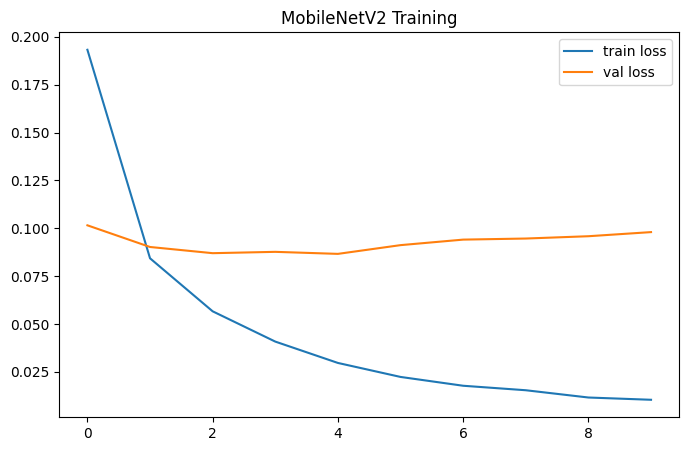

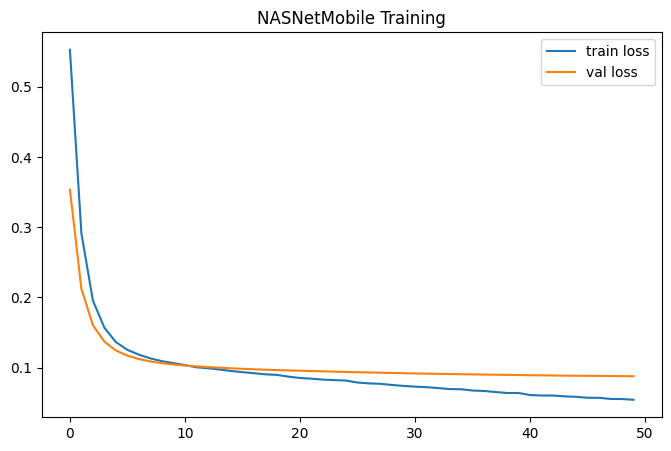

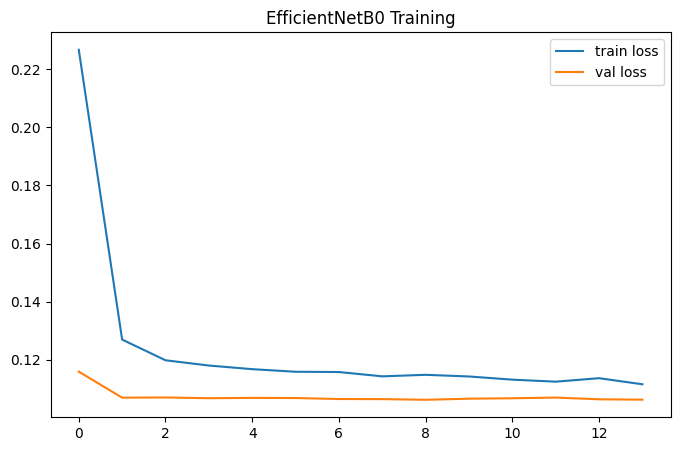

In [59]:
plot_history(history_mobilenet, "MobileNetV2 Training")
plot_history(history_nasnet, "NASNetMobile Training")
plot_history(history_efficientnet, "EfficientNetB0 Training")


In [64]:
import numpy as np
import pandas as pd

def compare_all_models_table(models, model_names, dataset, label_names, n_samples=20):
    """
    Creates a single table comparing predictions from multiple models.
    """
    results = {
        "Sample #": [],
        "True Labels": []
    }

    # Prepare columns dynamically
    for name in model_names:
        results[f"{name} Predictions"] = []

    count = 0

    for batch_images, batch_labels in dataset:
        # Precompute all model predictions for this batch
        batch_preds = [model.predict(batch_images) for model in models]

        for i in range(len(batch_images)):
            if count >= n_samples:
                break

            # True labels
            true_vec = batch_labels[i].numpy()
            true_labels = [label_names[j] for j, v in enumerate(true_vec) if v == 1]

            # Store row
            results["Sample #"].append(count)
            results["True Labels"].append(", ".join(true_labels))

            # Add predictions for each model
            for model_idx, name in enumerate(model_names):
                pred_vec = batch_preds[model_idx][i]
                pred_labels = [label_names[j] for j, v in enumerate(pred_vec > 0.5) if v]
                results[f"{name} Predictions"].append(", ".join(pred_labels))

            count += 1

        if count >= n_samples:
            break

    df = pd.DataFrame(results)
    return df


In [65]:
models = [mobilenet, nasnet, efficientnet]
model_names = ["MobileNetV2", "NASNetMobile", "EfficientNetB0"]

df_compare = compare_all_models_table(
    models,
    model_names,
    test_ds,
    unique_labels,
    n_samples=30
)

df_compare


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 997ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


,Sample #,True Labels,MobileNetV2 Predictions,NASNetMobile Predictions,EfficientNetB0 Predictions
0,0,Shakshuka,,Rice,
1,1,Kleija,,,
2,2,Basbousa,,Chicken,
3,3,Rice,Rice,Rice,
4,4,Foul,,,
5,5,"Meat, Vegetable",,,
6,6,Areeqa,Rice,,
7,7,Musabeeb,,,
8,8,Basbousa,,,
9,9,"Chicken, Rice",Rice,,
